In [1]:
#Load Libraries
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.nn.init
from torch.utils.data import Dataset
from torch.autograd import Variable
from PIL import Image
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchsummary
#import helper
import numpy as np
from tqdm import tqdm
from PIL import Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torchvision
from sklearn.svm import OneClassSVM


# GPU 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정   
torch.manual_seed(123)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(123)


In [4]:
import os
PATH = os.getcwd() + '/'

In [2]:
#alexnet 전처리
preprocess = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor(),
    transforms.CenterCrop(227),
    transforms.Grayscale(3),
])

In [151]:
data_labels = {
    0 : "Ban",
    1 : "Bicycle",
    2 : "Car",
    3 : "Circle",
    4 : "Down",
    5 : "Square",
    6 : "Triangle",
    7 : "Turn",
    8 : "Up"
    }


In [6]:
#데이터 불러오기
dataset = torchvision.datasets.ImageFolder(root=PATH + 'src/First/', transform=preprocess)

#데이터 로더 생성
data_loader = torch.utils.data.DataLoader(dataset)

#라벨별로 데이터셋 분할
label_to_data = {}
for images, labels in data_loader:
    for image, label in zip(images, labels):
        #라벨에 해당하는 데이터 가져오기
        if label.item() not in label_to_data:
            label_to_data[label.item()] = []
        label_to_data[label.item()].append(image)

#분할된 데이터셋 확인
for label, data in label_to_data.items():
    print(f"Label : {label}")
    print(f'Number of samples : {len(data)}')

c:\Users\asuin\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Label : 0
Number of samples : 26
Label : 1
Number of samples : 6
Label : 2
Number of samples : 14
Label : 3
Number of samples : 13
Label : 4
Number of samples : 1
Label : 5
Number of samples : 44
Label : 6
Number of samples : 2


In [7]:

for idx in range(7):
    for i in range(len(label_to_data[idx])):
        label_to_data[idx][i] = label_to_data[idx][i].unsqueeze(0)

In [18]:
print(len(label_to_data[0]))

44


In [59]:
class AlexNet(nn.Module):
    
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=96,kernel_size=11,stride=4,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(96,256,5,1,2),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,384,3,1,1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384,384,3,1,1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384,256,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(3,2)
        )
        
        self.fc1 = nn.Sequential(
            nn.Linear(256*6*6,4096)
        )
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)
        
        out = self.fc1(out)
        return out

In [75]:
class CNN(nn.Module):
    
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 3,out_channels=64,kernel_size=3,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2,padding=0,dilation=1,ceil_mode=False)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64,192,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0,1,False)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(192,256,3,1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(256,384,3,1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384,128,3,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2,0,1,False)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(0.5, inplace=False),
            nn.Linear(73728, 1024, bias=True),
            nn.ReLU(),
            nn.Dropout(0.5, inplace=False),
            nn.Linear(1024,512,True),
            nn.ReLU(),
            nn.Linear(512,2,True),
            nn.ReLU(),
            nn.Dropout(0.5, False)
        )
        
    def forward(self,x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

In [127]:
#Set hyper-parameter
learning_rate = 0.001
#training_epochs = 50
training_epochs = 1

In [128]:
#모델 정의

Model = [CNN().to(device)] * 9
SVM_Model = [OneClassSVM(gamma='auto', kernel='rbf')] * 9

In [129]:
from torchsummary import summary
summary(Model[0], input_size= (3,227,227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 225, 225]           1,792
              ReLU-2         [-1, 64, 225, 225]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 192, 110, 110]         110,784
              ReLU-5        [-1, 192, 110, 110]               0
         MaxPool2d-6          [-1, 192, 55, 55]               0
            Conv2d-7          [-1, 256, 53, 53]         442,624
              ReLU-8          [-1, 256, 53, 53]               0
            Conv2d-9          [-1, 384, 51, 51]         885,120
             ReLU-10          [-1, 384, 51, 51]               0
           Conv2d-11          [-1, 128, 49, 49]         442,496
             ReLU-12          [-1, 128, 49, 49]               0
        MaxPool2d-13          [-1, 128, 24, 24]               0
          Dropout-14                [-1

In [141]:
#0-9모델 학습
Features = [[],[],[],[],[],[],[],[],[]]
for Number_Model in range(7):
    #변수 설정
    Y = torch.tensor(0).unsqueeze(0)
    total_batch = len(label_to_data[Number_Model])
    criterion = nn.NLLLoss()
    optimizer = torch.optim.Adam(Model[Number_Model].parameters(), lr=learning_rate)



    #학습 시작
    print("{}번 모델 학습 시작".format(Number_Model))

    for epoch in range(training_epochs):
        avg_cost = 0
        for X in tqdm(label_to_data[Number_Model]):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()
            hypothesis = Model[Number_Model](X)

            if epoch == training_epochs-1:
                for hypo in range(len(hypothesis)):
                    x = []
                    for i in hypothesis[hypo]:
                        x.append(i.item())
                    Features[Number_Model].append(x)

            cost = criterion(hypothesis, Y)

            cost.backward
            optimizer.step()
            avg_cost = cost / total_batch

        print('[Epoch: {:>4}] cost = {:>.9}'.format(epoch + 1, avg_cost))



0번 모델 학습 시작


  0%|          | 0/26 [00:00<?, ?it/s]

100%|██████████| 26/26 [00:02<00:00,  9.89it/s]

[Epoch:    1] cost = 0.0


In [80]:
#SVM 모델 학습
for Number_Model in tqdm(range(7)):
    SVM_Model[Number_Model].fit(Features[Number_Model])

100%|██████████| 7/7 [00:00<00:00, 938.14it/s]


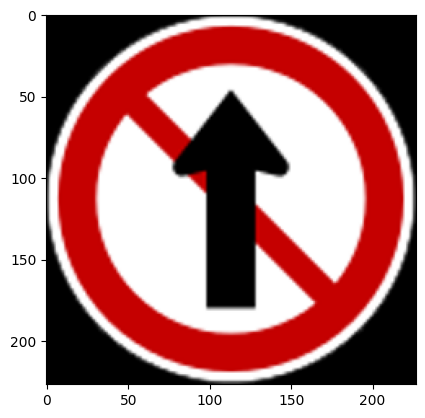

In [142]:
image = PATH+"src/CustomData/origin/Sign (15).png"

img = Image.open(image).convert('RGB').resize((227,227))

#이미지 출력
plt.imshow(img)

#이미지 -> numpy -> tensor
img = np.array(img)
img = img.astype(np.float32)
img = torch.from_numpy(img).permute(2, 0, 1)


In [148]:
# 이미지 테스트 
Test_result = []
with torch.no_grad():
    for Number_Model in range(7):
        X = img.unsqueeze(0).to(device)
        predictions = Model[Number_Model](X)
        
        #print(predictions[:100])
        #SVM
        #Test_result.append(SVM_Model[Number_Model].predict(predictions))
        print(predictions[0])
        Test_result.append(predictions)
print(Test_result)

tensor([0.4980, 0.0000])
[tensor([[0.4980, 0.0000]])]
